# **Simple Neural Network**

## **Imports**

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, 
                             precision_score, f1_score, classification_report)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, clear_output
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping

## **Parse TFR**

In [2]:
def parse_tfr(proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    rec = tf.io.parse_single_example(proto, feature_description)
    image = tf.image.decode_jpeg(rec['image'], channels=3)
    label = rec['label']
    return image, label

train_file = 'data/oversampled_train_images.tfrecords'
val_file = 'data/preprocessed_val_images.tfrecords'
test_file = 'data/preprocessed_test_images.tfrecords'

train_dataset = tf.data.TFRecordDataset(train_file)
train_dataset = train_dataset.map(parse_tfr)

val_dataset = tf.data.TFRecordDataset(val_file)
val_dataset = val_dataset.map(parse_tfr)

test_dataset = tf.data.TFRecordDataset(test_file)
test_dataset = test_dataset.map(parse_tfr)


In [3]:
num_train_examples = sum(1 for _ in train_dataset)
num_val_examples = sum(1 for _ in val_dataset)
num_test_examples = sum(1 for _ in test_dataset)

print(f">> Number of examples in the training dataset: {num_train_examples}")
print(f">> Number of examples in the validation dataset: {num_val_examples}")
print(f">> Number of examples in the test dataset: {num_test_examples}")

>> Number of examples in the training dataset: 4464
>> Number of examples in the validation dataset: 1280
>> Number of examples in the test dataset: 1


## **Helper Functions**

In [4]:
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochen")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric])
        ax[idx].legend(['train_' + metric, 'val_' + metric])
        ax[idx].grid(True) 
        ax[idx].set_title(f'{metric.capitalize()}')

    plt.tight_layout()
    plt.show()

def validate(model, val_dataset, class_names=None):
    val_labels = []
    predictions = []

    for image, label in val_dataset:
        val_labels.append(label.numpy())
        prediction = model.predict(image)  # Predict a single image at a time
        predictions.append(prediction)

    val_labels = np.array(val_labels)
    predictions = np.vstack(predictions)

    predicted_labels = np.argmax(predictions, axis=1)

    # Flatten batched arrays to ensure equal length
    val_labels = val_labels.flatten()
    predicted_labels = predicted_labels.flatten()

    confusion = confusion_matrix(val_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Calculate overall metrics
    overall_metrics_df = pd.DataFrame({
        "Metric": ["Accuracy", "Weighted Recall", "Weighted Precision", "Weighted F1 Score"],
        "Value": [
            accuracy_score(val_labels, predicted_labels),
            recall_score(val_labels, predicted_labels, average='weighted'),
            precision_score(val_labels, predicted_labels, average='weighted'),
            f1_score(val_labels, predicted_labels, average='weighted')
        ]
    })

    print("Overall Metrics:")
    print(overall_metrics_df)
    print("\n")

    print("Classification Report (Validation):")
    print(classification_report(val_labels, predicted_labels, target_names=class_names))


def visualize_predictions(model, dataset, class_names, num_images=20, image_size=(3, 3), fontsize=8):
    images = []
    true_labels = []
    predicted_labels = []

    for i, (image, label) in enumerate(dataset):
        if i >= num_images:
            break
        images.append(image.numpy())
        true_labels.append(class_names[label.numpy()[0]])

        prediction = model.predict(np.expand_dims(image, axis=0))

        predicted_label = class_names[np.argmax(prediction)]
        predicted_labels.append(predicted_label)

    num_rows = int(np.ceil(num_images / 4))
    fig, axes = plt.subplots(num_rows, 4, figsize=(image_size[0] * 4, image_size[1] * num_rows))

    for i, (image, true_label, predicted_label) in enumerate(zip(images, true_labels, predicted_labels)):
        ax = axes[i // 4, i % 4]
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}", fontsize=fontsize)

    for i in range(num_images, num_rows * 4):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    display(plt.gcf())
    clear_output(wait=True)



## **Neural Network Model**

In [5]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='softmax', input_shape=(300, 300, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(4, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False), metrics=['accuracy'])


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 710432)            0         
                                                                 
 dense (Dense)               (None, 4)                 2841732   
                                                                 
Total params: 2,842,628
Trainable params: 2,842,628
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Trainiere das Modell mit den Trainingsdaten
batch_size = 16

train_dataset = train_dataset.batch(batch_size).shuffle(buffer_size=10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
279/279 [==============================] - 24s 76ms/step - loss: 4.2012 - accuracy: 0.5421 - val_loss: 1.3938 - val_accuracy: 0.5461
Epoch 2/10
279/279 [==============================] - 17s 60ms/step - loss: 2.5257 - accuracy: 0.6620 - val_loss: 1.3573 - val_accuracy: 0.7523
Epoch 3/10
279/279 [==============================] - 17s 58ms/step - loss: 1.4838 - accuracy: 0.7749 - val_loss: 1.0260 - val_accuracy: 0.6156
Epoch 4/10
279/279 [==============================] - 17s 58ms/step - loss: 0.9439 - accuracy: 0.8233 - val_loss: 2.2555 - val_accuracy: 0.5867
Epoch 5/10
279/279 [==============================] - 17s 57ms/step - loss: 1.0734 - accuracy: 0.8315 - val_loss: 2.5630 - val_accuracy: 0.7711
Epoch 6/10
279/279 [==============================] - 17s 57ms/step - loss: 2.4176 - accuracy: 0.7650 - val_loss: 1.2686 - val_accuracy: 0.8438
Epoch 7/10
279/279 [==============================] - 18s 56ms/step - loss: 0.6772 - accuracy: 0.8860 - val_loss: 1.1985 - val_accuracy:

#### Runtime 2m 55s

## **Validation**

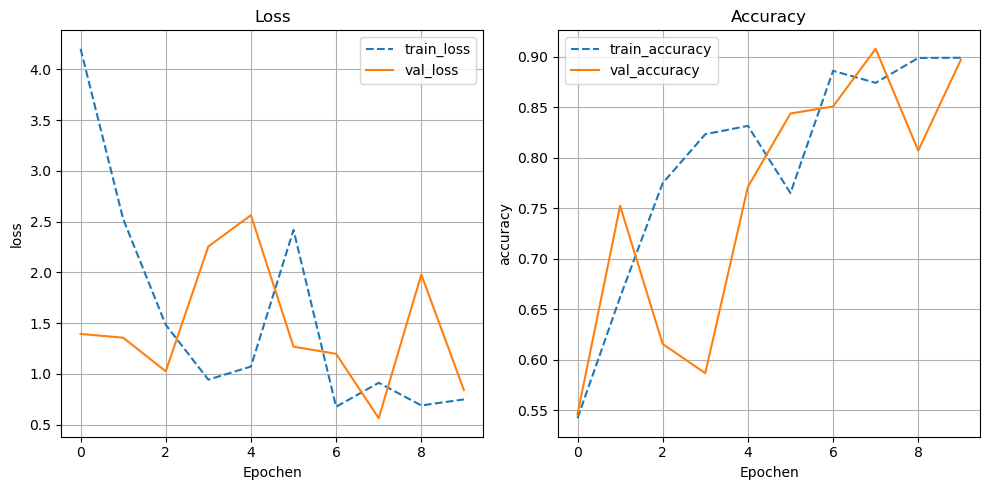

In [8]:
training_plot(["loss", "accuracy"], history)

1/1 [==============================] - 0s 29ms/step


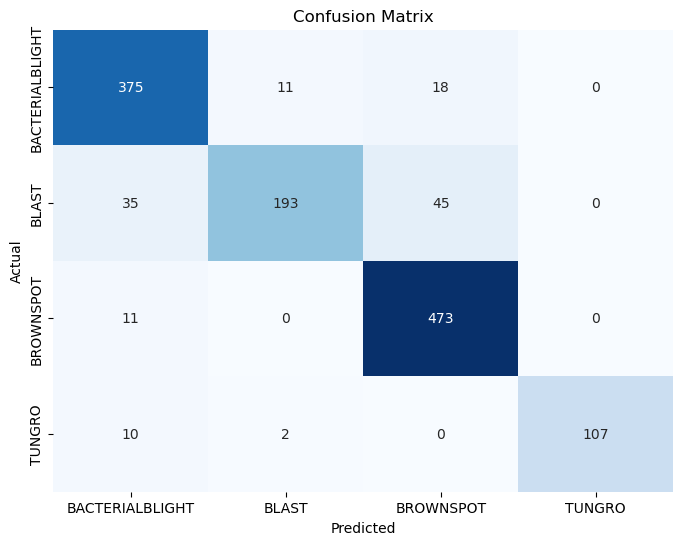

Overall Metrics:
               Metric     Value
0            Accuracy  0.896875
1     Weighted Recall  0.896875
2  Weighted Precision  0.901087
3   Weighted F1 Score  0.894092


Classification Report (Validation):
                 precision    recall  f1-score   support

BACTERIALBLIGHT       0.87      0.93      0.90       404
          BLAST       0.94      0.71      0.81       273
      BROWNSPOT       0.88      0.98      0.93       484
         TUNGRO       1.00      0.90      0.95       119

       accuracy                           0.90      1280
      macro avg       0.92      0.88      0.89      1280
   weighted avg       0.90      0.90      0.89      1280



In [9]:
validate(model, val_dataset, class_names=["BACTERIALBLIGHT", "BLAST", "BROWNSPOT", "TUNGRO"])